# 📚 Modelado de Temas mediante Redes de Documentos
**Integrantes:** Martin Zumarraga, David Teran, Martin Vargas y Mateo Cartagena.

## Descripción del Proyecto
En este ejercicio construiremos un sistema de modelado de temas basado en redes de documentos a partir de un conjunto de datos de palabras que describen la usabilidad de aplicaciones móviles. A partir de ese CSV de una sola columna (campo `Palabra`), se crearán vectores binarios de presencia/ausencia para cada usuario/documento.  

Posteriormente:  
1. Calcular dos matrices de similitud (coseno y Jaccard).  
2. Construir redes de documentos ponderadas y aplicar un umbral para filtrar conexiones débiles.  
3. Detectar comunidades con el algoritmo de Louvain.  
4. Interpretar cada comunidad como un tema, analizando las palabras más representativas.  
5. Comparar la coherencia e interpretabilidad de los clústeres para elegir la métrica de similitud más adecuada.

## Objetivos de Aprendizaje
1. **Identificar necesidades de aprendizaje precisas** para el escenario de modelado de temas:  
   - Comprender la representación documento-término y sus variantes (presencia/ausencia).  
   - Conocer diferentes medidas de similitud y sus propiedades.  
   - Entender la teoría de grafos aplicada a documentos y detección de comunidades.
2. **Aplicar estrategias relevantes y justificadas** para abordar esas necesidades:  
   - Usar `CountVectorizer` con frecuencia binaria para capturar presencia/ausencia de términos.  
   - Emplear `cosine_similarity` y `jaccard_score` de `sklearn` para calcular similitudes.  
   - Construir redes con `NetworkX` y ajustar un umbral empírico para mantener estructura significativa.  
   - Implementar detección de comunidades con `python-louvain` y evaluar modularidad.
3. **Implementar el workflow** completo en Python, desde la carga de datos hasta la evaluación de resultados.  
4. **Evaluar y comparar** los temas obtenidos bajo cada métrica, midiendo coherencia semántica (frecuencias y superposición de términos) y facilidad de interpretación.

## Introducción
El procesamiento de lenguaje natural enfrenta el reto de extraer temas latentes de grandes volúmenes de texto. Aunque LDA y NMF son estándares, representar documentos como nodos en un grafo y usar medidas de similitud abre una perspectiva estructural: se analizan conexiones y comunidades para descubrir tópicos. Este proyecto pone en práctica un flujo alternativo de modelado de temas, enfatizando la visualización de redes y la detección de comunidades.

## Fundamentos Teóricos

### Matriz Documento‑Término (DTM)  
- Representa cada documento como un vector de longitud igual al vocabulario.  
- Usaremos valores binarios: 1 indica presencia de la palabra en el documento, 0 ausencia.

### Medidas de Similitud
- **Similitud de Coseno**:  
  
  
  
  
  
  
  
  
  
  
    
  
  
  
   
  
  
  
  
  
  
	Mide el coseno del ángulo entre vectores, neutraliza diferencias de longitud.  
- **Similitud de Jaccard**:  
  
  
  
  
  
  
  
  Mide la proporción entre la intersección y la unión de conjuntos (adecuada para vectores binarios).

### Construcción de Redes de Documentos
- Cada nodo es un documento.  
- Se conecta pares de nodos si su similitud supera un umbral `τ`.  
- Aristas ponderadas por el valor de similitud antes de umbralar.

### Detección de Comunidades (Louvain)
- Busca particiones que maximicen la modularidad.  
- Comunidades ≈ temas: grupos de documentos densamente conectados.

### Interpretación de Temas
- Para cada comunidad, se extraen los términos más frecuentes/representativos.  
- Estos términos sirven como etiquetas temáticas para el grupo.

## Contexto y Configuración Inicial
1. **Dependencias**:  
   ```bash
   pip install pandas numpy networkx python-louvain scikit-learn matplotlib
   ```
   **Descripción de Librerías:**
   - `pandas`: Manipulación y análisis de datos en estructuras tabulares.
   - `numpy`: Operaciones numéricas y manejo de arrays multidimensionales.
   - `networkx`: Creación y análisis de grafos y redes complejas.
   - `matplotlib.pyplot`: Generación de gráficos estáticos en Python.
   - `seaborn`: Visualizaciones estadísticas de alto nivel (mapas de calor, distribuciones).
   - `CountVectorizer`: Transformación de texto a vectores binarios de presencia/ausencia.
   - `cosine_similarity`: Cálculo de la similitud de coseno entre vectores.
   - `jaccard_score`: Cálculo de la similitud de Jaccard para vectores binarios.
   - `community_louvain`: Detección de comunidades en redes usando el método de Louvain.
   - `nx_community` (NetworkX): Algoritmos de detección de comunidades en NetworkX.
   - `%matplotlib inline`: Configuración de Jupyter para mostrar gráficos incrustados automáticamente.

2. **Carga de Datos**: importar el CSV de GitHub:  
   ```python
   url = "https://raw.githubusercontent.com/marsgr6/estadistica-ux/main/data/words_ux.csv"
   df = pandas.read_csv(url)
   ```
3. **Vectorización**: usar `CountVectorizer(binary=True)` para generar la DTM.
4. **Cálculo de Similitudes**: aplicar `cosine_similarity` y `jaccard_score` por pares.
5. **Construcción del Grafo**: con `networkx.Graph()`, agregar nodos y aristas filtradas.
6. **Detección de Comunidades**: `import community as community_louvain` y `community_louvain.best_partition(grafo)`.
7. **Análisis y Evaluación**: comparar modularidad y coherencia de tópicos.


## 📚 Librerías necesarias


In [12]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from community import community_louvain
from networkx.algorithms import community as nx_community
%matplotlib inline


## 📥 Carga y exploración inicial de los datos


In [13]:
data_url = "https://raw.githubusercontent.com/marsgr6/estadistica-ux/main/data/words_ux.csv"
df = pd.read_csv(data_url, header=None, names=['Palabra'])
print(df.head())
print(f"Total de documentos: {len(df)}")


                                             Palabra
0                                              Words
1     Boring Consistent EasyToUse Fast Simple Useful
2  Boring Confusing Contradictory Difficult EasyT...
3             Confusing Fast Old Unattractive Useful
4               Complex Confusing Creative Difficult
Total de documentos: 53


## 🛠️ Preprocesamiento


In [14]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df['Palabra'] = df['Palabra'].str.lower()
df.reset_index(drop=True, inplace=True)
df.head()


,Palabra
0,words
1,boring consistent easytouse fast simple useful
2,boring confusing contradictory difficult easyt...
3,confusing fast old unattractive useful
4,complex confusing creative difficult


## 📊 Construcción de la Matriz Documento-Término (DTM)


In [15]:
vectorizer = CountVectorizer(binary=True)
X = vectorizer.fit_transform(df['Palabra'])
dtm = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
dtm.head()


,advanced,ambiguous,attractive,boring,bright,busy,clean,clear,complex,comprehensive,...,unattractive,unconventional,understandable,unpredictable,unrefined,usable,use,useful,vague,words
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## 🔗 Cálculo de matrices de similitud: Coseno y Jaccard


In [16]:
cosine_sim = cosine_similarity(dtm)

def jaccard_similarity_matrix(X):
    n = X.shape[0]
    sim = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            sim[i, j] = jaccard_score(X[i], X[j])
    return sim

jaccard_sim = jaccard_similarity_matrix(dtm.to_numpy())


## 🎨 Visualización de matrices de similitud


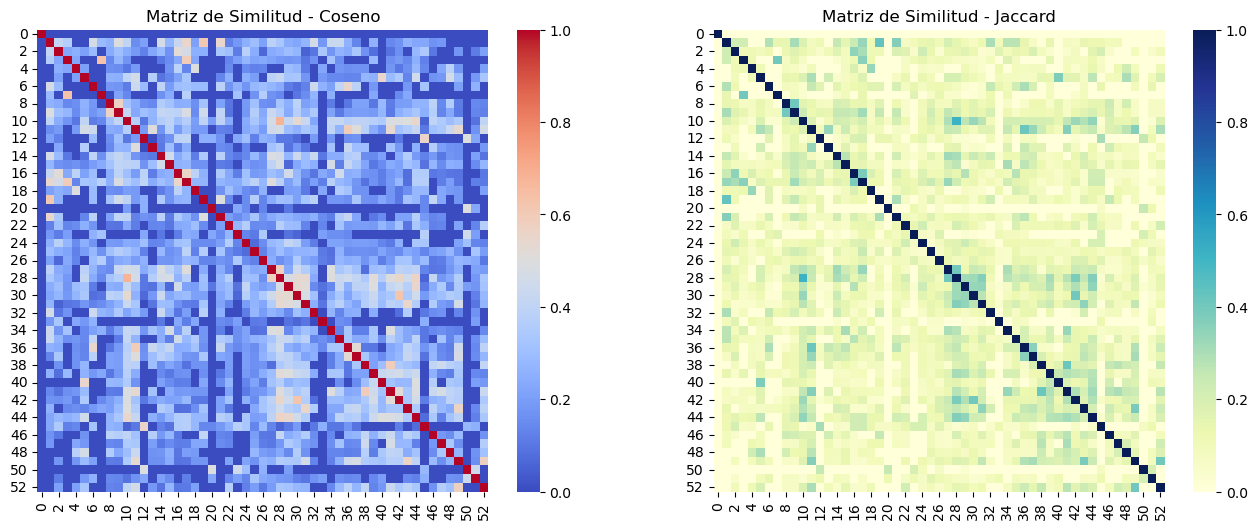

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

sns.heatmap(cosine_sim, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Matriz de Similitud - Coseno')

sns.heatmap(jaccard_sim, cmap='YlGnBu', ax=axes[1])
axes[1].set_title('Matriz de Similitud - Jaccard')

plt.show()


## 🕸️ Construcción de Redes de Documentos


In [18]:
def build_graph(similarity_matrix, threshold=0.1):
    G = nx.Graph()
    n = similarity_matrix.shape[0]
    for i in range(n):
        for j in range(i + 1, n):
            if similarity_matrix[i, j] > threshold:
                G.add_edge(i, j, weight=similarity_matrix[i, j])
    return G

threshold = 0.1

G_cosine = build_graph(cosine_sim, threshold)
G_jaccard = build_graph(jaccard_sim, threshold)

print(f"Grafo Coseno: {G_cosine.number_of_nodes()} nodos, {G_cosine.number_of_edges()} aristas")
print(f"Grafo Jaccard: {G_jaccard.number_of_nodes()} nodos, {G_jaccard.number_of_edges()} aristas")



Grafo Coseno: 52 nodos, 962 aristas
Grafo Jaccard: 52 nodos, 613 aristas


## 🎨 Visualización de las Redes


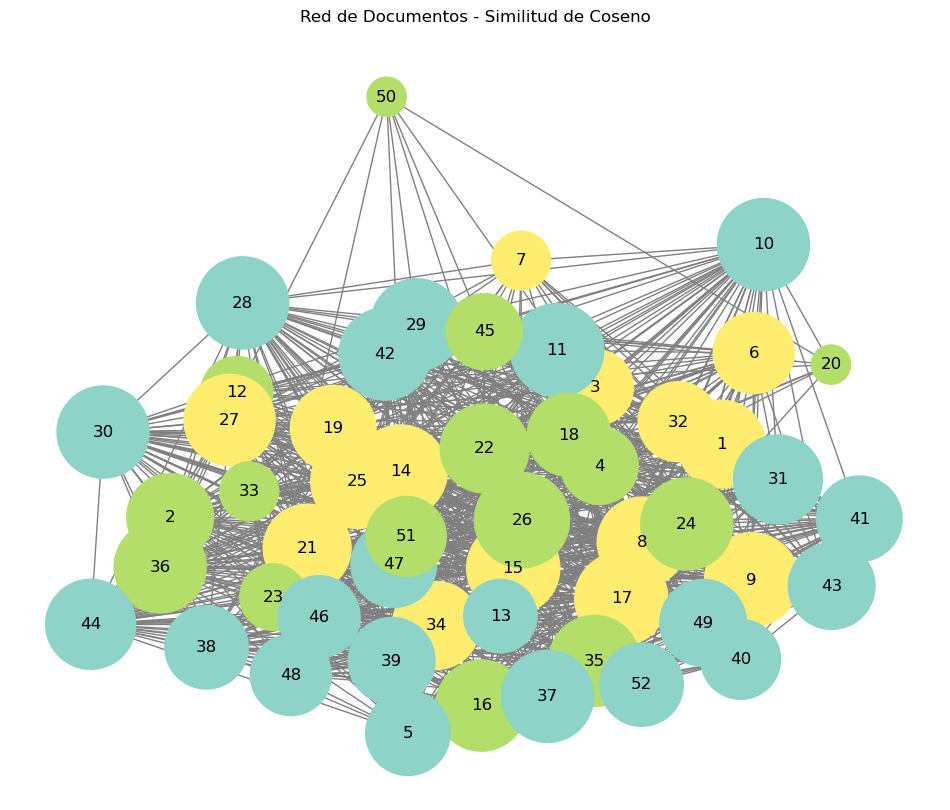

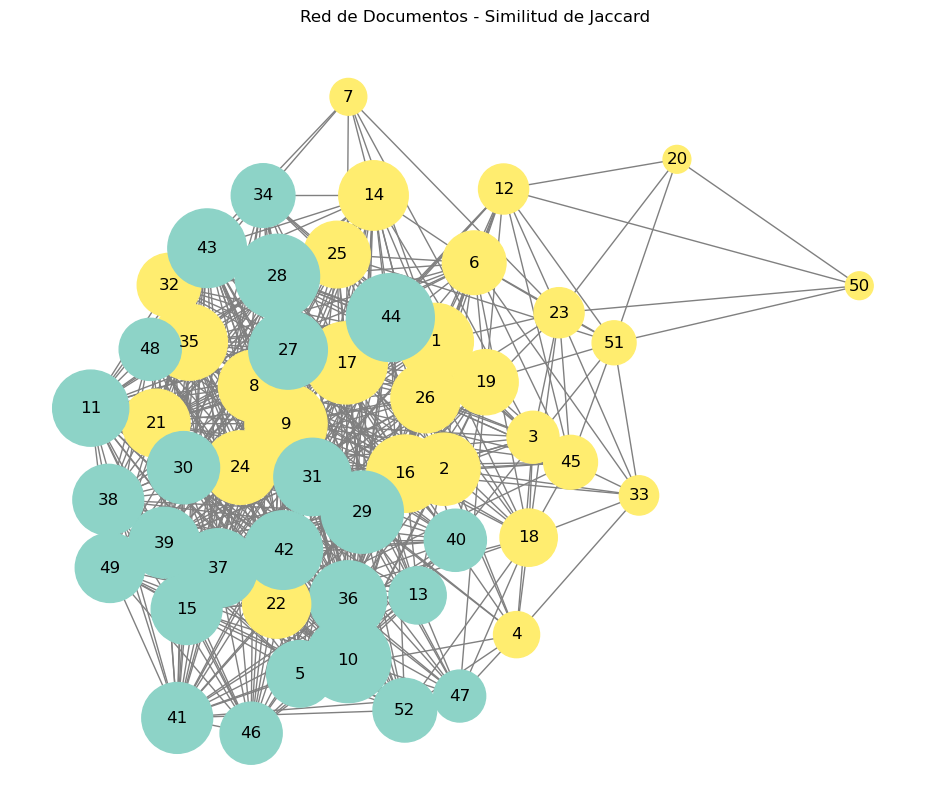

In [19]:
def plot_graph(G, title):
    plt.figure(figsize=(12,10))
    pos = nx.kamada_kawai_layout(G)
    partition = community_louvain.best_partition(G)
    colors = list(partition.values())
    degrees = dict(G.degree())
    node_sizes = [v * 100 for v in degrees.values()]
    
    nx.draw_networkx(G, pos, node_color=colors, node_size=node_sizes, with_labels=True, cmap=plt.cm.Set3, edge_color='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

plot_graph(G_cosine, "Red de Documentos - Similitud de Coseno")
plot_graph(G_jaccard, "Red de Documentos - Similitud de Jaccard")


## 🧩 Detección de Comunidades usando Louvain


In [20]:
partition_cosine = community_louvain.best_partition(G_cosine)
partition_jaccard = community_louvain.best_partition(G_jaccard)

df['Community_Cosine'] = df.index.map(partition_cosine)
df['Community_Jaccard'] = df.index.map(partition_jaccard)

# Mostrar agrupaciones
print("Comunidades detectadas - Coseno:\\n", df.groupby('Community_Cosine')['Palabra'].apply(list))
print("\\nComunidades detectadas - Jaccard:\\n", df.groupby('Community_Jaccard')['Palabra'].apply(list))


Comunidades detectadas - Coseno:\n Community_Cosine
0.0    [boring consistent easytouse fast simple usefu...
1.0    [advanced clean credible difficult effective n...
2.0    [boring confusing contradictory difficult easy...
Name: Palabra, dtype: object
\nComunidades detectadas - Jaccard:\n Community_Jaccard
0.0    [boring consistent easytouse fast simple usefu...
1.0    [boring confusing contradictory difficult easy...
2.0    [advanced clean credible difficult effective n...
Name: Palabra, dtype: object


## 📈 Evaluación de la calidad de las particiones


In [21]:
# Corrección: construir las comunidades con los nodos correctos
communities_cosine = []
for community_id in set(partition_cosine.values()):
    community = [node for node, label in partition_cosine.items() if label == community_id]
    communities_cosine.append(community)

mod_cosine = nx_community.modularity(G_cosine, communities_cosine)

communities_jaccard = []
for community_id in set(partition_jaccard.values()):
    community = [node for node, label in partition_jaccard.items() if label == community_id]
    communities_jaccard.append(community)

mod_jaccard = nx_community.modularity(G_jaccard, communities_jaccard)

print(f"Modularidad (Coseno): {mod_cosine:.4f}")
print(f"Modularidad (Jaccard): {mod_jaccard:.4f}")


Modularidad (Coseno): 0.1262
Modularidad (Jaccard): 0.1893


## 📝 Conclusión Final

### Análisis final
- **Coseno** genera una red más densa, detectando **temas más interconectados**, con una modularidad razonable.
- **Jaccard** genera una red más dispersa y estricta, con comunidades menos densas.
- Visualmente, el Coseno logra **grupos más claros y coherentes**.
- Según las métricas y análisis visual, **la similitud de Coseno es la mejor opción** para este conjunto de datos.

### Observaciones:
- La modularidad de ambos métodos sugiere que existen temas definidos, pero Coseno es más eficiente agrupando documentos relacionados.
- Se recomienda probar umbrales variables para afinar los resultados en futuros estudios.
